# example: Keras 2D convolutional neural network on MNIST

In [1]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.utils import plot_model
import matplotlib.pylab as plt

Using TensorFlow backend.


In [2]:
# input dimensions
img_x       = 28
img_y       = 28

In [3]:
# Load MNIST data into training and testing datasets. The x data are the features and the y data are the labels.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

num_classes = 10

In [4]:
# Reshape the data into a 4D tensor (sample_number, x_img_size, y_img_size, num_channels).
# MNIST is greyscale, which corresponds to a single channel/dimension.
# Alternatively, color, for example RGB, would correspond to three channels/dimensions.
x_train     = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test      = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x, img_y, 1)

# Cast the data as type float32.
x_train     = x_train.astype('float32')
x_test      = x_test.astype('float32')
x_train     = x_train / 255
x_test      = x_test  / 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [5]:
# Convert class vectors to binary class matrices for use in the categorical_crossentropy loss.
y_train     = keras.utils.to_categorical(y_train, num_classes)
y_test      = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train[0] # labels

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [7]:
y_train.shape

(60000, 10)

In [8]:
x_train[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

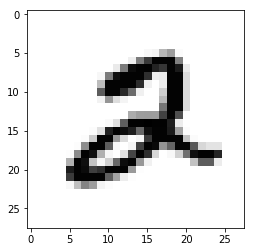

In [9]:
plt.imshow(
    x_train[5].reshape(28, 28),
    cmap          = "Greys",
    interpolation = "nearest"
)
plt.show()

In [10]:
model = Sequential()

# Add a 2D convolutional layer to process the 2D input (image) data.
model.add(
    Conv2D(
        32,                       # number of output channels
        kernel_size = (5, 5),     # kernel: 5 x 5 moving window
        strides     = (1, 1),     # kernel strides in the x and y dimensions
        activation  = 'relu',     # activation function: ReLU
        input_shape = input_shape # input size/shape
    )
)
# Add a 2D max pooling layer.
model.add(
    MaxPooling2D(
        pool_size   = (2, 2),     # size of the pooling in the x and y dimensions
        strides     = (2, 2)      # strides in the x and y dimensions
    )
)
# Add a convolutional layer. The input tensor for this layer is (batch_size, 28, 28, 32),
# where 28 x 28 corresponds to the input dimensions and 32 is the number of output channels from the previous layer.
model.add(
    Conv2D(
        64,                       # number of output channels
        (5, 5),                   # kernel: 5 x 5 moving window
        strides     = (1, 1),     # kernel strides in x and y dimensions -- default: (1, 1)
        activation  = 'relu'      # activation function: ReLU
    )
)
# Add a dropout layer.
model.add(Dropout(0.5))
# Add a 2D max pooling layer.
model.add(
    MaxPooling2D(
        pool_size   = (2, 2)      # size of the pooling in the x and y dimensions
    )
)
# Flatten the output from convolutional layers to prepare them for input to fully-connected layers.
model.add(Flatten())
# Specify a fully-connected layer.
model.add(
    Dense(
        1000,                     # number of nodes
        activation  = 'relu'      # activation function: ReLU
    )
)
# Specify a fully-connected output layer.
model.add(
    Dense(
        num_classes,              # number of classes
        activation  = 'softmax'   # softmax classification
    )
)
plot_model(model, to_file="model.png")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1025000   
__________

In [11]:
model.compile(
    loss            = keras.losses.categorical_crossentropy,
    optimizer       = keras.optimizers.Adam(), # alternative: keras.optimizers.SGD(lr = 0.01)
    metrics         = ['accuracy']
)

# Define a callback class which is to be passed to the model fitting function
# as an element of a list of possible callbacks.
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.acc = []
    def on_epoch_end(self, batch, logs = {}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath       = 'best_model.{epoch:02d}-{val_loss:.2f}.h5',
    monitor        = 'val_loss',
    save_best_only = True
)

In [12]:
epochs = 50

model.fit(
    x_train,
    y_train,
    batch_size      = 512,
    epochs          = epochs,
    verbose         = 1,
    validation_data = (x_test, y_test),
    callbacks       = [history, checkpoint]
)
score = model.evaluate(x_test, y_test, verbose = False)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2883 - acc: 0.9146 - val_loss: 0.0922 - val_acc: 0.9785
Epoch 2/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0719 - acc: 0.9782 - val_loss: 0.0631 - val_acc: 0.9849
Epoch 3/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0502 - acc: 0.9850 - val_loss: 0.0453 - val_acc: 0.9892
Epoch 4/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0390 - acc: 0.9880 - val_loss: 0.0379 - val_acc: 0.9908
Epoch 5/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0330 - acc: 0.9895 - val_loss: 0.0288 - val_acc: 0.9917
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0269 - acc: 0.9915 - val_loss: 0.0266 - val_acc: 0.9924
Epoch 7/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.0239 - acc: 0.9927 - val_loss: 0.0309 - val_acc

test loss: 0.019951582571061225
test accuracy: 0.9948


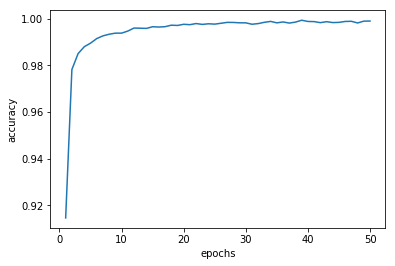

In [13]:
print('test loss:', score[0])
print('test accuracy:', score[1])
plt.plot(range(1, epochs + 1), history.acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()